In [1]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array
from hera_filters import dspec
%matplotlib notebook

In [26]:
nfreqs = 1500
nants = 50
npix = 100
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.75
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

antpos = linear_array(nants, sep=5)

bls = []
scale = 1
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)


In [27]:
ant_amp = np.random.uniform(0.5, 1.5, (len(antpos), nfreqs))
ant_phase = np.random.uniform(0, 2 * np.pi, (len(antpos), nfreqs))


In [28]:
vis_dict = {}
model_dict = {}
ci = 0
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            g1 = ant_amp[ai] * np.exp(1j * ant_phase[ai])
            g2 = ant_amp[aj] * np.exp(1j * ant_phase[aj])
            vis_dict[(ai, aj)] = V_sky[ci] * g1 * g2.conj()
            vis_dict[(aj, ai)] = vis_dict[(ai, aj)].conj()
            #model_dict[(ai, aj)] = V_sky_inc[ci]
            model_dict[(ai, aj)] = V_sky[ci]
            model_dict[(aj, ai)] = model_dict[(ai, aj)].conj()
            ci += 1
            
            


In [29]:
from jax import numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

In [61]:
@jax.jit
def stefcal_optimizer(data_matrix, model_matrix, weights, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    def inner_function(args):
        """
        Main optimization loop
        """
        gains, i, tau = args
        g_old = jnp.copy(gains)
        zg = gains[:, None] * model_matrix
        zgw = zg * weights
        gains = jnp.sum(jnp.conj(data_matrix) * zgw, axis=(0)) / jnp.sum(jnp.conj(zgw) * zg, axis=(0))
        gains = gains * stepsize + g_old * (1 - stepsize)
        
        # Compute convergence criterea
        tau = jnp.sqrt(jnp.sum(jnp.abs(gains - g_old) ** 2))/ jnp.sqrt(jnp.sum(jnp.abs(gains)**2))
        return gains, i + 1, tau
    
    def conditional_function(args):
        """
        Conditional function to check to convergence criterea
        """
        _, i, tau = args
        return (tau > tol) & (i < maxiter)
    
    nants = data_matrix.shape[0]
    gains = jnp.ones(nants, dtype=complex)
    
    return jax.lax.while_loop(conditional_function, inner_function, (gains, 0, 1))

def run_stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    gains = []
    niter = []
    for i in range(data_matrix.shape[-1]):
        g, i, tau = stefcal_optimizer(data_matrix[..., i], model_matrix[..., i], wgts[..., i], tol=tol, maxiter=maxiter, stepsize=stepsize)
        gains.append(g)
        niter.append(i)
        
    return np.array(gains).T, np.array(niter).T

def skycal(data, model, wgts, data_bls, model_bls, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    Perform a full-sky based calibration using the StEFCal algorithm
    """
    return gains

In [62]:
from hera_cal import abscal

In [63]:
abscal.complex_phase_abscal??

In [53]:
%%time
Nants = nants
fi = 0

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

for n in range(Nants):
    for m in range(Nants):
        if n != m:
            data_matrix[m, n] = vis_dict[(m, n)]
            model_matrix[m, n] = model_dict[(m, n)]
            

wgts = np.ones_like(model_matrix).real
wgts[2, 5, 50] = 0.0
wgts[5, 2, 50] = 0.0


wgts[2, 5, 57] = 0.0
wgts[5, 2, 57] = 0.0

CPU times: user 58.6 ms, sys: 35.8 ms, total: 94.5 ms
Wall time: 120 ms


In [55]:
%%time
gstef, niter = run_stefcal(data_matrix, model_matrix, wgts, maxiter=1000, tol=1e-10, stepsize=0.5)

CPU times: user 4.1 s, sys: 11.7 ms, total: 4.12 s
Wall time: 4.12 s


In [56]:
Gf = gstef[:, None, :] * gstef[None, ...].conj()

<IPython.core.display.Javascript object>


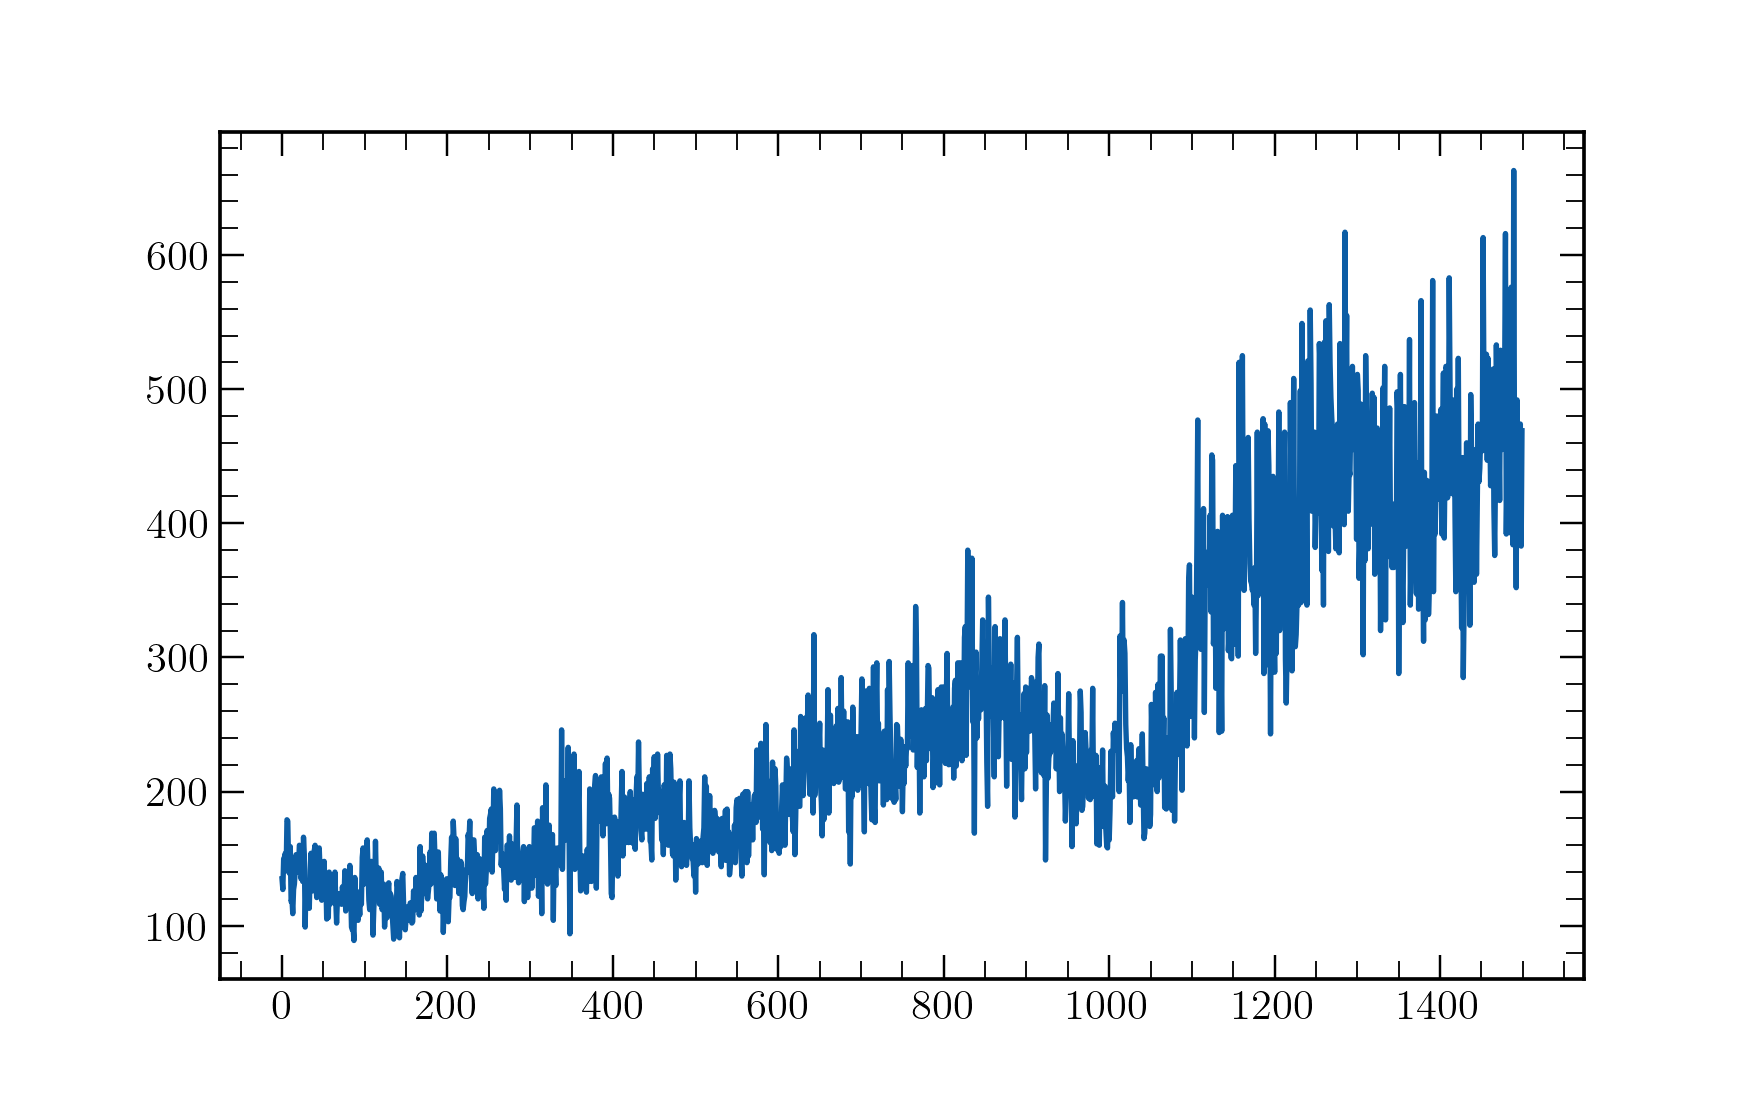

In [57]:
plt.figure()
plt.plot(niter)

In [58]:
cal_f = data_matrix / Gf

In [59]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

<IPython.core.display.Javascript object>


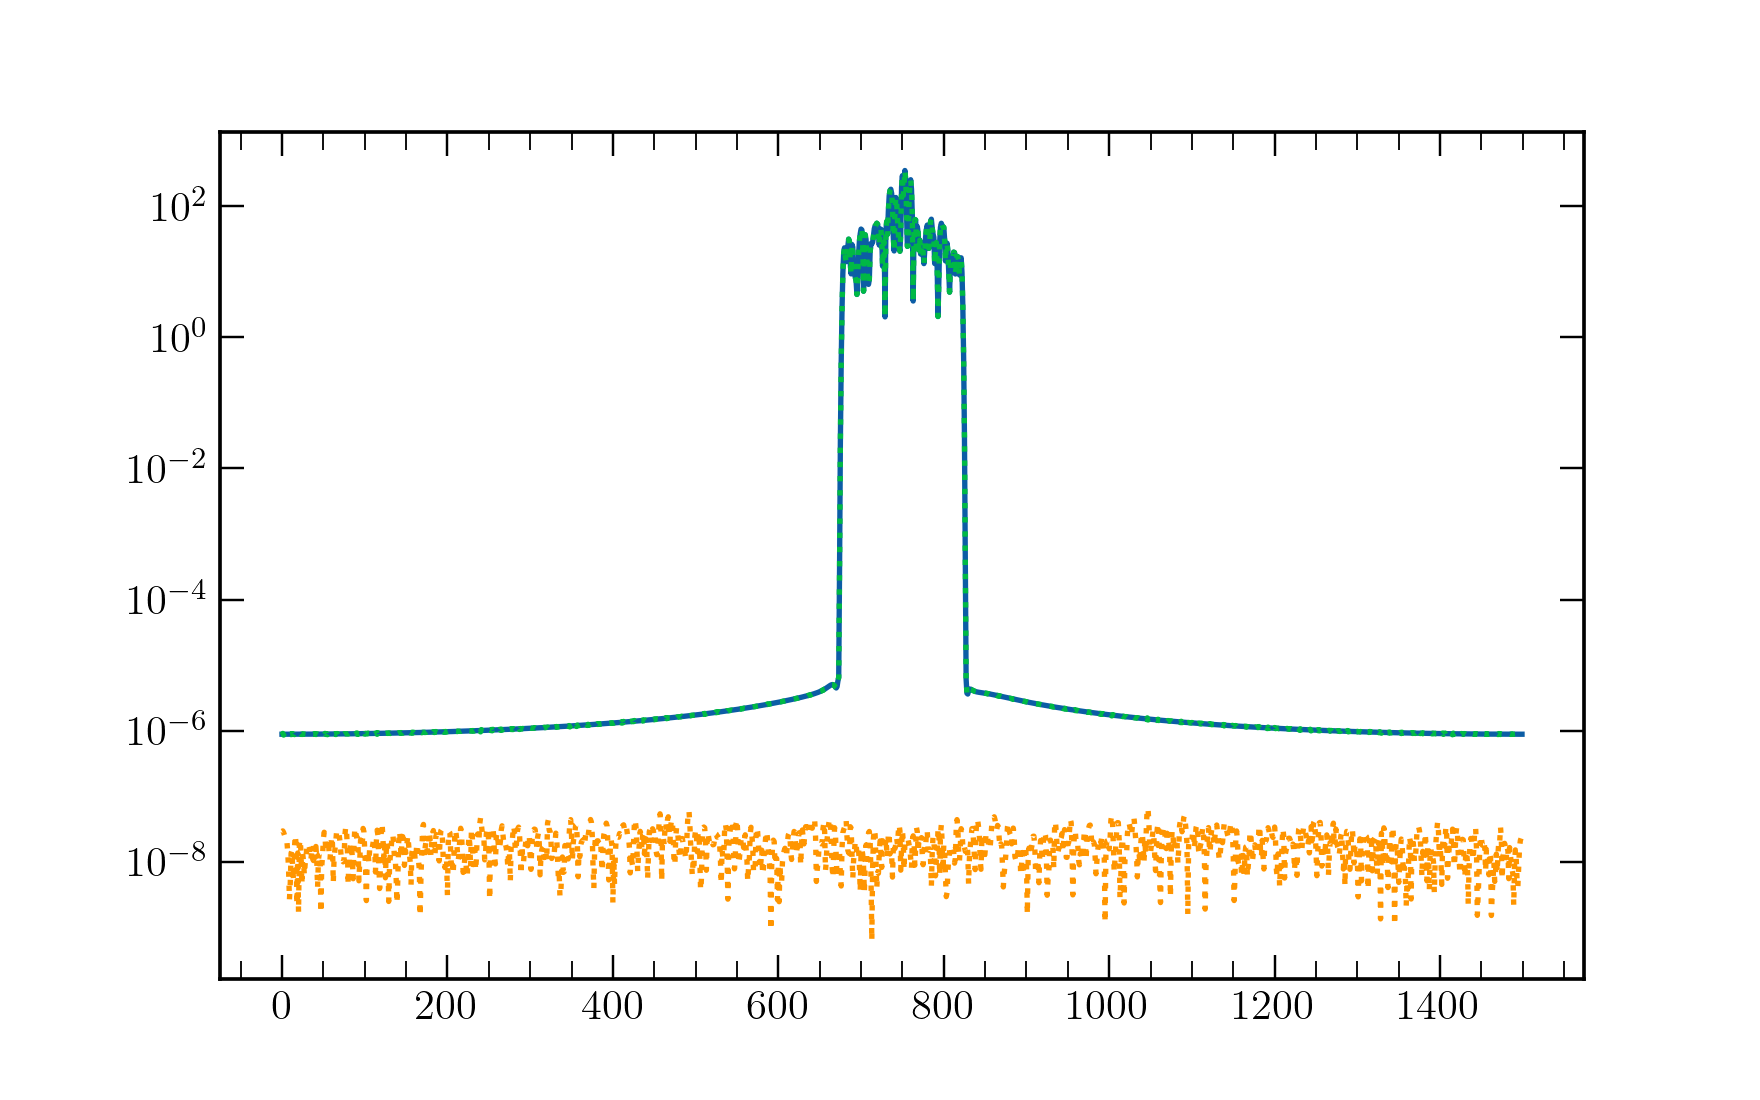

In [60]:
plt.figure()
plt.semilogy(delay_spectra(model_matrix[0, 20]))
plt.semilogy(delay_spectra(cal_f[0, 20]), ls=':')
plt.semilogy(delay_spectra(model_matrix[0, 20] - cal_f[0, 20]), ls=':')
plt.show()